In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PowerTransformer
import lightgbm as lgb
import shap
import optuna
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder

In [7]:
df = pd.read_csv('../../../data/processed/land_dataset_final_v2.csv')

In [8]:
df.dropna(inplace=True)

In [9]:
df.head()

,address_subdivision,address_locality,address_line_2,h_id,price_per_m2,land_area,price,longitude,latitude,near_Koh_Pich_in_km,...,f_road,f_secondary,f_service,f_steps,f_tertiary,f_track,f_trunk,f_trunk_link,f_unclassified,f_unused
0,Phnom Penh,Mean Chey,Stueng Mean Chey,8865846a91fffff,3068.33,52,52,104.883100,11.552932,6,...,0,1,1,0,0,0,0,0,0,0
1,Phnom Penh,Chamkar Mon,Phsar Daeum Thkov,8865846acbfffff,3632.23,178,178,104.915003,11.528833,3,...,0,0,0,0,0,0,0,0,0,0
2,Phnom Penh,Saensokh,Phnom Penh Thmei,88658468cbfffff,3123.13,138,138,104.886163,11.586713,7,...,0,0,1,0,0,0,0,0,0,0
3,Phnom Penh,Saensokh,Phnom Penh Thmei,8865846ab1fffff,3434.37,162,162,104.889529,11.575790,6,...,0,0,0,0,0,0,0,0,0,0
4,Phnom Penh,Doun Penh,Chakto Mukh,8865846a39fffff,3855.90,200,200,104.958218,11.558388,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# cols = ['price', 'geometry', 'index_right', 'ADM1_EN', 'polygon_geom']
# df.drop(columns=cols, inplace=True)

In [11]:
grouped = df.groupby('h_id')['price_per_m2']
df['h_id_price_mean'] = df['h_id'].map(grouped.mean())
df['h_id_price_max'] = df['h_id'].map(grouped.max())
df['h_id_price_median'] = df['h_id'].map(grouped.median())
df['h_id_price_min'] = df['h_id'].map(grouped.min())

In [12]:
# df.to_csv('../../../data/processed/mockup_dataset_road_min_max.csv')

In [13]:
df

,address_subdivision,address_locality,address_line_2,h_id,price_per_m2,land_area,price,longitude,latitude,near_Koh_Pich_in_km,...,f_tertiary,f_track,f_trunk,f_trunk_link,f_unclassified,f_unused,h_id_price_mean,h_id_price_max,h_id_price_median,h_id_price_min
0,Phnom Penh,Mean Chey,Stueng Mean Chey,8865846a91fffff,3068.33,52,52,104.883100,11.552932,6,...,0,0,0,0,0,0,3011.727778,3240.50,3047.460,2622.25
1,Phnom Penh,Chamkar Mon,Phsar Daeum Thkov,8865846acbfffff,3632.23,178,178,104.915003,11.528833,3,...,0,0,0,0,0,0,3818.351026,4961.91,3806.730,2560.65
2,Phnom Penh,Saensokh,Phnom Penh Thmei,88658468cbfffff,3123.13,138,138,104.886163,11.586713,7,...,0,0,0,0,0,0,3702.541837,4619.43,3593.130,3059.76
3,Phnom Penh,Saensokh,Phnom Penh Thmei,8865846ab1fffff,3434.37,162,162,104.889529,11.575790,6,...,0,0,0,0,0,0,3308.530714,4527.88,3242.455,2855.43
4,Phnom Penh,Doun Penh,Chakto Mukh,8865846a39fffff,3855.90,200,200,104.958218,11.558388,1,...,0,0,0,0,0,0,3963.536364,5619.81,3973.660,1745.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,Phnom Penh,Chraoy Chongvar,Bak Kaeng,886586a699fffff,661.63,182,182,104.929226,11.701893,16,...,0,0,0,0,0,0,615.868333,699.64,636.920,496.69
9268,Phnom Penh,Chraoy Chongvar,Preaek Ta Sek,8865846995fffff,410.11,212,212,104.899855,11.667508,13,...,0,0,0,0,0,0,898.133333,1685.02,895.275,407.13
9269,Phnom Penh,Praek Pnov,Ponsang,8865846d85fffff,251.75,134,134,104.756877,11.633307,22,...,0,0,0,0,0,0,201.678889,251.75,184.580,167.49
9270,Phnom Penh,Pur SenChey,Kantaok,8865846e31fffff,1020.13,230,230,104.785133,11.523526,17,...,0,0,0,0,0,0,1007.350667,1238.65,1020.120,792.92


In [14]:
X = df.drop(['price_per_m2','longitude','latitude','address_subdivision','h_id', 'address_locality', 'price', 'geometry'], axis=1, errors='ignore')
y = df['price_per_m2']

In [15]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['address_line_2'], dtype='object')

In [16]:
# Temporarily encode categorical columns for feature selection
X_temp = X.copy()
if len(cat_cols) > 0:
    encoder = OrdinalEncoder()
    X_temp[cat_cols] = encoder.fit_transform(X_temp[cat_cols])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42)

In [18]:
model = GradientBoostingRegressor(random_state=42)

# Recursive Feature Elimination
selector = RFE(model, n_features_to_select=20, step=1)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

In [19]:
print("Selected features:", selected_features.tolist())

Selected features: ['address_line_2', 'near_Koh_Pich_in_km', 'near_AEON_Mall_1_in_km', 'near_Bassac_Lane_in_km', 'near_Boeng_Keng_Kang_1_in_km', 'near_Royal_Palace_in_km', 'n_cafe_in_1km_to_2km', 'nearest_hotel', 'n_hotel_in_3km_to_5km', 'nearest_resturant', 'n_resturant_in_1km', 'n_super_market_in_1km_to_2km', 'n_bank_5km', 'nearest_bank', 'n_bank_in_1km_to_2km', 'n_atm_5km', 'nearest_atm', 'h_id_price_mean', 'h_id_price_median', 'h_id_price_min']


In [20]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

In [21]:
# 5. Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train_sel, y_train)
    
    score = model.score(X_test_sel, y_test)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-07-02 16:24:32,025] A new study created in memory with name: no-name-391d1c31-827c-4e58-b6ae-99a16b8bc414


[I 2025-07-02 16:24:34,462] Trial 0 finished with value: 0.9785218481709138 and parameters: {'n_estimators': 561, 'learning_rate': 0.019209789520734308, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.8353699585262568, 'max_features': 'log2'}. Best is trial 0 with value: 0.9785218481709138.
[I 2025-07-02 16:24:39,811] Trial 1 finished with value: 0.9818999984668009 and parameters: {'n_estimators': 1062, 'learning_rate': 0.26728662325410196, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 10, 'subsample': 0.744512755681672, 'max_features': 'log2'}. Best is trial 1 with value: 0.9818999984668009.
[I 2025-07-02 16:24:44,727] Trial 2 finished with value: 0.9843955103210449 and parameters: {'n_estimators': 846, 'learning_rate': 0.12799449640121735, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3, 'subsample': 0.7591242571918533, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9843955103210449.
[I 2025-07-02 16:24:50,476] Tria

Best parameters: {'n_estimators': 1086, 'learning_rate': 0.03780914753713385, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7959364309427467, 'max_features': None}


In [22]:

# 6. Train Final Model
final_model = GradientBoostingRegressor(**best_params)
final_model.fit(X_train_sel, y_train)

GradientBoostingRegressor(learning_rate=0.03780914753713385, max_depth=6,
                          min_samples_leaf=3, min_samples_split=4,
                          n_estimators=1086, subsample=0.7959364309427467)

C:\Users\User\AppData\Local\Temp\ipykernel_14844\989701320.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


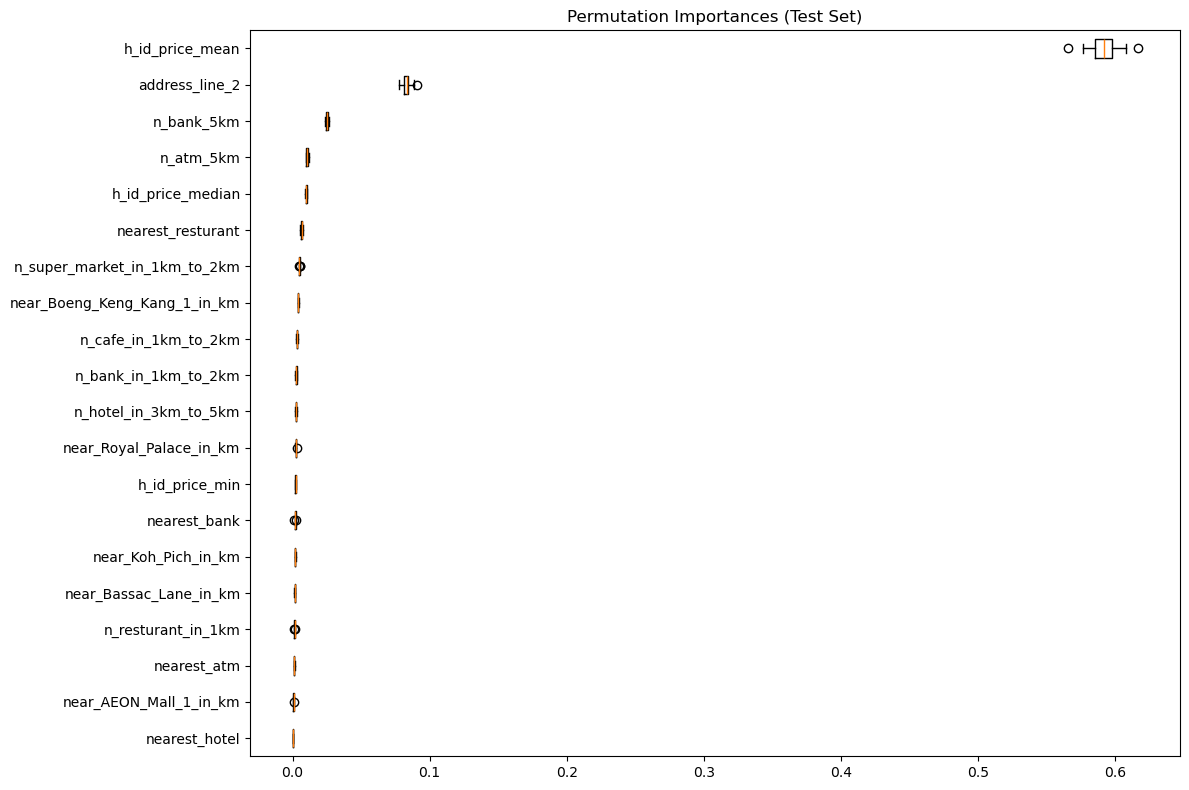

In [23]:
# 7. Evaluate Feature Importance
# Permutation importance
result = permutation_importance(
    final_model, 
    X_test_sel, 
    y_test, 
    n_repeats=20,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_test_sel.columns[sorted_idx]
)
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.savefig("permutation_importance.png")
plt.show()


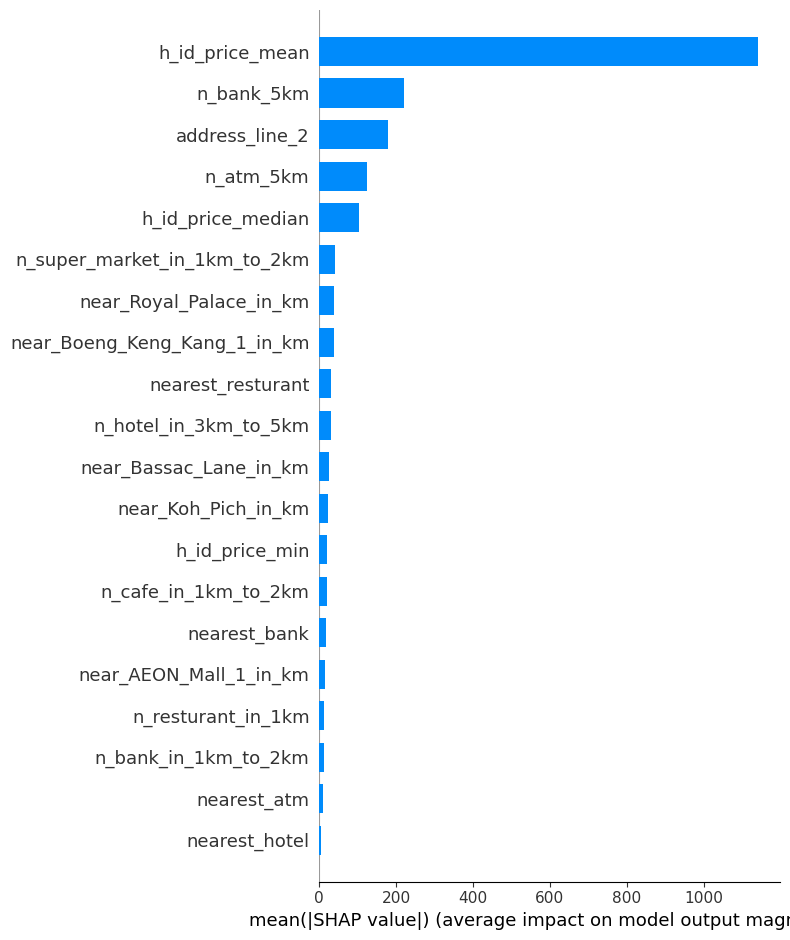

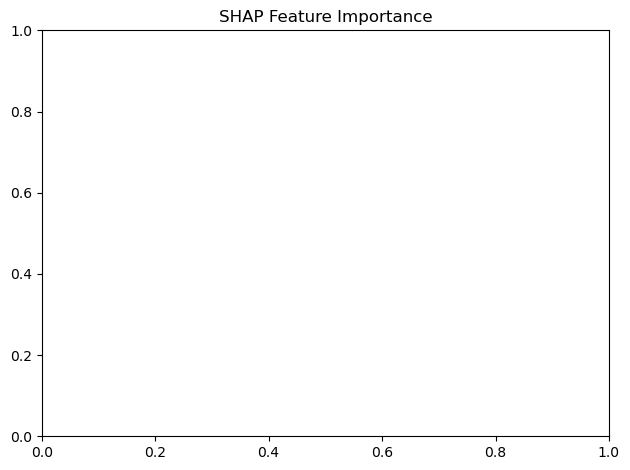

In [24]:
# SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_sel)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sel, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig("shap_importance.png")
plt.show()

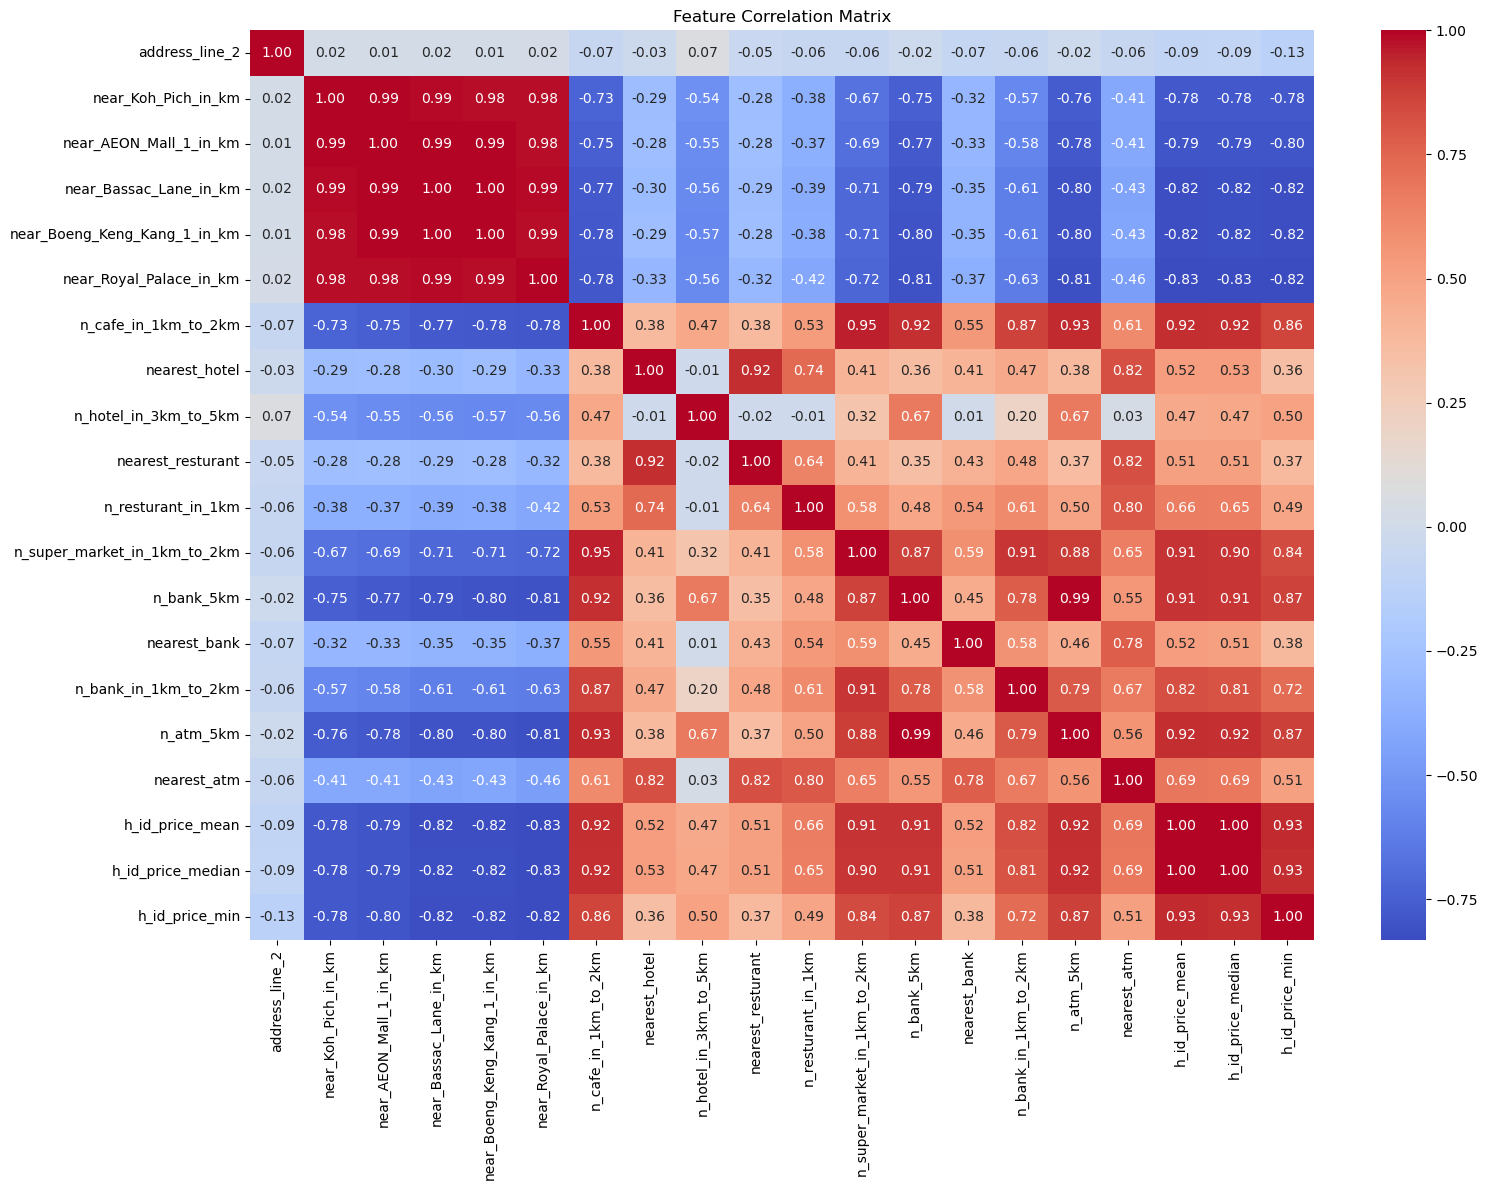

In [25]:
# 8. Feature Correlation Analysis
plt.figure(figsize=(16, 12))
corr_matrix = X_train_sel.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("feature_correlation.png")
plt.show()

In [26]:

# 9. Generate Diagnostic Report
print("\n===== MODEL DIAGNOSTICS REPORT =====")
print(f"Original features: {len(X.columns)}")
print(f"Selected features: {len(selected_features)}")
print(f"Validation R Sqare score: {study.best_value:.4f}")



===== MODEL DIAGNOSTICS REPORT =====
Original features: 230
Selected features: 20
Validation R Sqare score: 0.9877


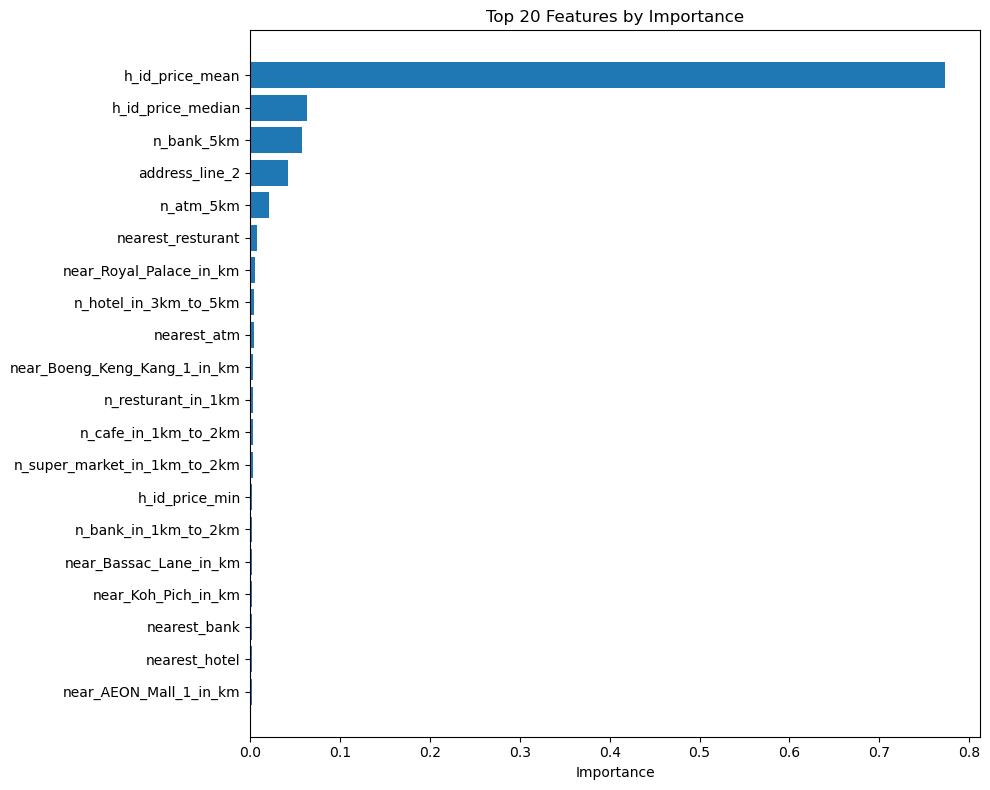

In [27]:
# Top features by importance
feature_importance = pd.DataFrame({
    'Feature': X_test_sel.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance.head(top_n)['Feature'][::-1],  # reverse for descending order
    feature_importance.head(top_n)['Importance'][::-1]
)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Features by Importance')
plt.tight_layout()
plt.show()

In [28]:
from sklearn.preprocessing import OneHotEncoder

# Select only the categorical columns that are in the selected features
cat_selected = [col for col in cat_cols if col in selected_features]

# One-hot encode categorical features in X[selected_features]
if cat_selected:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(X[cat_selected])

    # Transform and create DataFrame for encoded features
    X_ohe = pd.DataFrame(
        ohe.transform(X[cat_selected]),
        index=X.index,
        columns=ohe.get_feature_names_out(cat_selected)
    )

    # Drop original categorical columns and concatenate encoded columns
    X_sel_enc = pd.concat([X[selected_features].drop(columns=cat_selected), X_ohe], axis=1)
else:
    X_sel_enc = X[selected_features].copy()

In [29]:
X_sel_enc

,near_Koh_Pich_in_km,near_AEON_Mall_1_in_km,near_Bassac_Lane_in_km,near_Boeng_Keng_Kang_1_in_km,near_Royal_Palace_in_km,n_cafe_in_1km_to_2km,nearest_hotel,n_hotel_in_3km_to_5km,nearest_resturant,n_resturant_in_1km,...,address_line_2_Tuek Thla,address_line_2_Tumnob Tuek,address_line_2_Tuol Sangke,address_line_2_Tuol Svay Prey Ti Muoy,address_line_2_Tuol Svay Prey Ti Pir,address_line_2_Tuol Tumpung Ti Muoy,address_line_2_Tuol Tumpung Ti Pir,address_line_2_Veal Sbov,address_line_2_Veal Vong,address_line_2_Voat Phnum
0,6,5,4,4,5,16,0,36,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,2,2,2,4,23,0,63,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,6,5,5,5,26,0,48,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,5,4,4,4,26,1,75,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,3,3,3,2,0,74,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,16,17,16,16,15,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9268,13,13,13,13,11,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9269,22,21,20,20,20,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9270,17,16,15,15,16,0,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_sel_enc

,near_Koh_Pich_in_km,near_AEON_Mall_1_in_km,near_Bassac_Lane_in_km,near_Boeng_Keng_Kang_1_in_km,near_Royal_Palace_in_km,n_cafe_in_1km_to_2km,nearest_hotel,n_hotel_in_3km_to_5km,nearest_resturant,n_resturant_in_1km,...,address_line_2_Tuek Thla,address_line_2_Tumnob Tuek,address_line_2_Tuol Sangke,address_line_2_Tuol Svay Prey Ti Muoy,address_line_2_Tuol Svay Prey Ti Pir,address_line_2_Tuol Tumpung Ti Muoy,address_line_2_Tuol Tumpung Ti Pir,address_line_2_Veal Sbov,address_line_2_Veal Vong,address_line_2_Voat Phnum
0,6,5,4,4,5,16,0,36,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,2,2,2,4,23,0,63,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,6,5,5,5,26,0,48,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,5,4,4,4,26,1,75,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,3,3,3,2,0,74,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,16,17,16,16,15,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9268,13,13,13,13,11,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9269,22,21,20,20,20,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9270,17,16,15,15,16,0,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
full_selected = pd.concat([X_sel_enc, y], axis=1)


In [32]:
full_selected.to_csv("../../../data/preprocessed/feature_selection_by_model_final_data_20feature.csv", index=False)